# Load Packages

In [0]:
%%capture
!pip install "tensorflow>=2.0.0"
!pip install git+https://github.com/kmedian/keras-layernorm-rnn.git
!pip install lagmat

In [0]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

from keras_layernorm_rnn import (
    LayernormSimpleRNN, LayernormLSTM1, LayernormLSTM2, LayernormLSTM3)
from lagmat import lagmat

import matplotlib.pyplot as plt
%matplotlib inline

# Generate Fake Dataset

In [0]:
n_obs = 2000    
delta = 0.05 
sigma = 0.5

t = np.arange(0, n_obs)
dat = np.cos(delta * t) + sigma * np.random.randn(n_obs)

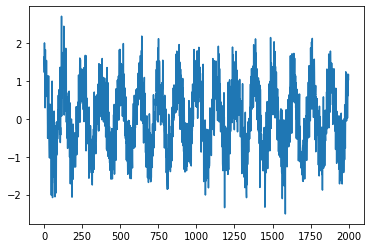

In [4]:
plt.plot(t, dat);

In [0]:
n_inp_steps = int(1. / delta)
n_out_steps = 1

mat = lagmat(dat, lags=range(n_inp_steps + n_out_steps))

In [6]:
print(mat[:6, :6])

[[1.63150982        nan        nan        nan        nan        nan]
 [1.22599206 1.63150982        nan        nan        nan        nan]
 [2.00390277 1.22599206 1.63150982        nan        nan        nan]
 [1.52511023 2.00390277 1.22599206 1.63150982        nan        nan]
 [1.1073663  1.52511023 2.00390277 1.22599206 1.63150982        nan]
 [1.58785417 1.1073663  1.52511023 2.00390277 1.22599206 1.63150982]]


In [0]:
# chop the nan away
idx_start = n_inp_steps + n_out_steps - 1
mat = mat[idx_start:, :]

In [0]:
# divide into y, X
X, y = mat[:, :n_inp_steps], mat[:, n_inp_steps:]

In [0]:
# data splitting
n_train = int(n_obs * 0.8)
X_train, X_valid = X[:n_train, :], X[n_train:, :]
Y_train, Y_valid = y[:n_train, :], y[n_train:, :]

In [0]:
# reshape for Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
Y_train = Y_train.reshape(-1, 1)
Y_valid = Y_valid.reshape(-1, 1)

In [11]:
X_valid.shape, Y_valid.shape

((380, 20, 1), (380, 1))

# SimpleRNN

## model_srn1 - SimpleRNN

In [0]:
n_features = 1   # Input sequence is a simple univariate time series
n_targets = 1  # Output sequence is a simple univariate time series
n_rnn = 8
n_relu = 3

model_srn1 = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(
        units=n_rnn,
        input_shape=(n_inp_steps, n_features),
        return_sequences=False,  # Many-to-One
    ),
    tf.keras.layers.Dense(n_relu, activation='relu'),  # sparse activity
    tf.keras.layers.Dense(n_targets, activation='linear'),
])

opt_args = {
    'loss': 'mean_squared_error',
    'optimizer': tf.keras.optimizers.Adam(1e-4)
}

model_srn1.compile(**opt_args)

## model_srn2 - LayernormSimpleRNN with Gamma

In [0]:
model_srn2 = tf.keras.Sequential([
    LayernormSimpleRNN(
        units=n_rnn,
        input_shape=(n_inp_steps, n_features),
        return_sequences=False,  # Many-to-One
    ),
    tf.keras.layers.Dense(n_relu, activation='relu'),  # sparse activity
    tf.keras.layers.Dense(n_targets, activation='linear'),
])


model_srn2.compile(**opt_args)

## model_srn3 - LayernormSimpleRNN without Gamma

In [0]:
model_srn3 = tf.keras.Sequential([
    LayernormSimpleRNN(
        units=n_rnn,
        use_gamma=False,
        input_shape=(n_inp_steps, n_features),
        return_sequences=False,  # Many-to-One
    ),
    tf.keras.layers.Dense(n_relu, activation='relu'),  # sparse activity
    tf.keras.layers.Dense(n_targets, activation='linear'),
])


model_srn3.compile(**opt_args)

## Training

In [0]:
train_args = {
    'epochs': 100,
    'batch_size': 16, 
    'steps_per_epoch': n_train // 16,
    'validation_data': (X_valid, Y_valid),
    'verbose': 0
}

In [16]:
history = []
for m in [model_srn1, model_srn2, model_srn3]:
    %time h = m.fit(X_train, Y_train, **train_args)
    history.append(h)

CPU times: user 57.9 s, sys: 3.23 s, total: 1min 1s
Wall time: 43.4 s
CPU times: user 1min 49s, sys: 4.13 s, total: 1min 53s
Wall time: 1min 12s
CPU times: user 1min 38s, sys: 3.86 s, total: 1min 42s
Wall time: 1min 5s


## Results

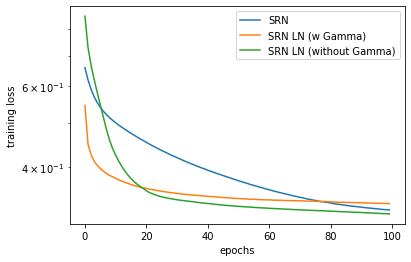

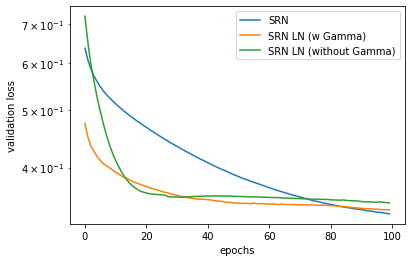

In [17]:
for key in ["loss", "val_loss"]:
    for h in history:
        plt.plot(h.history[key])
    plt.legend(["SRN", "SRN LN (w Gamma)", "SRN LN (without Gamma)"])
    plt.xlabel("epochs")
    plt.ylabel("training loss" if key == "loss" else "validation loss")
    plt.yscale("log")
    plt.show()

# LSTM

## Normal LSTM vs LayernormLSTM1-3

In [0]:
model_lstm0 = tf.keras.Sequential([
    tf.keras.layers.LSTM(
        units=n_rnn,
        input_shape=(n_inp_steps, n_features),
        return_sequences=False,  # Many-to-One
    ),
    tf.keras.layers.Dense(n_relu, activation='relu'),  # sparse activity
    tf.keras.layers.Dense(n_targets, activation='linear'),
])

model_lstm0.compile(**opt_args)

In [0]:
model_lstm1 = tf.keras.Sequential([
    LayernormLSTM1(
        units=n_rnn,
        input_shape=(n_inp_steps, n_features),
        return_sequences=False,  # Many-to-One
    ),
    tf.keras.layers.Dense(n_relu, activation='relu'),  # sparse activity
    tf.keras.layers.Dense(n_targets, activation='linear'),
])

model_lstm1.compile(**opt_args)

In [0]:
model_lstm2 = tf.keras.Sequential([
    LayernormLSTM2(
        units=n_rnn,
        input_shape=(n_inp_steps, n_features),
        return_sequences=False,  # Many-to-One
    ),
    tf.keras.layers.Dense(n_relu, activation='relu'),  # sparse activity
    tf.keras.layers.Dense(n_targets, activation='linear'),
])

model_lstm2.compile(**opt_args)

In [0]:
model_lstm3 = tf.keras.Sequential([
    LayernormLSTM3(
        units=n_rnn,
        input_shape=(n_inp_steps, n_features),
        return_sequences=False,  # Many-to-One
    ),
    tf.keras.layers.Dense(n_relu, activation='relu'),  # sparse activity
    tf.keras.layers.Dense(n_targets, activation='linear'),
])

model_lstm3.compile(**opt_args)

## Training

In [22]:
history = []
for m in [model_lstm0, model_lstm1, model_lstm2, model_lstm3]:
    %time h = m.fit(X_train, Y_train, **train_args)
    history.append(h)

CPU times: user 1min 48s, sys: 5.07 s, total: 1min 53s
Wall time: 1min 9s
CPU times: user 5min 28s, sys: 19.1 s, total: 5min 47s
Wall time: 3min 11s
CPU times: user 4min 59s, sys: 16.3 s, total: 5min 15s
Wall time: 2min 55s
CPU times: user 5min 37s, sys: 20.7 s, total: 5min 58s
Wall time: 3min 26s


## Results

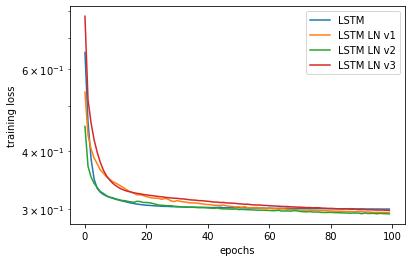

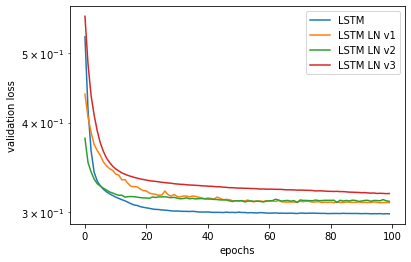

In [23]:
for key in ["loss", "val_loss"]:
    for h in history:
        plt.plot(h.history[key])
    plt.legend(["LSTM", "LSTM LN v1", "LSTM LN v2", "LSTM LN v3"])
    plt.xlabel("epochs")
    plt.ylabel("training loss" if key == "loss" else "validation loss")
    plt.yscale("log")
    plt.show()

## Check Gamma Weights

In [24]:
for arr in model_lstm1.layers[0].cell.get_weights()[3:]:
    print(np.round(arr, 3))

[0.999 0.989 1.049 0.993 0.989 1.083 0.989 0.984]
[1.022 0.973 1.028 0.988 1.027 0.913 0.967 0.967]
[0.974 1.057 1.008 1.043 1.035 1.068 0.998 1.02 ]
[1.082 1.046 0.99  1.013 0.982 0.971 1.041 0.973]


In [25]:
for arr in model_lstm2.layers[0].cell.get_weights()[3:]:
    print(np.round(arr, 3))

[1.047 1.014 1.011 1.038 0.982 0.946 0.986 0.96 ]
[0.955 0.98  0.947 1.041 1.016 0.962 1.049 0.996]
[1.028 1.116 0.997 1.049 1.065 1.077 1.02  1.043]
[1.024 1.002 1.017 1.018 1.076 0.864 1.038 1.047]


In [26]:
for arr in model_lstm3.layers[0].cell.get_weights()[12:]:
    print(np.round(arr, 3))

[1.048 0.94  1.074 1.06  0.967 1.014 0.931 0.883]
[0.968 0.973 1.039 1.034 1.048 0.972 1.005 0.977]
[0.979 0.958 1.093 0.878 0.907 1.002 0.954 1.019]
[0.911 0.97  1.154 0.965 0.96  1.061 0.965 0.866]


# LSTM vs LSTM LN with Gamma vs LSTM LV without Gamma

In [0]:
model_lstm4 = tf.keras.Sequential([
    LayernormLSTM3(
        units=n_rnn,
        use_gamma=False,
        input_shape=(n_inp_steps, n_features),
        return_sequences=False,  # Many-to-One
    ),
    tf.keras.layers.Dense(n_relu, activation='relu'),  # sparse activity
    tf.keras.layers.Dense(n_targets, activation='linear'),
])

model_lstm4.compile(**opt_args)

In [28]:
%%time
history4 = model_lstm4.fit(X_train, Y_train, **train_args)

CPU times: user 5min 7s, sys: 18.9 s, total: 5min 25s
Wall time: 3min 6s


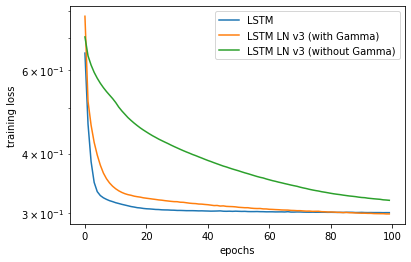

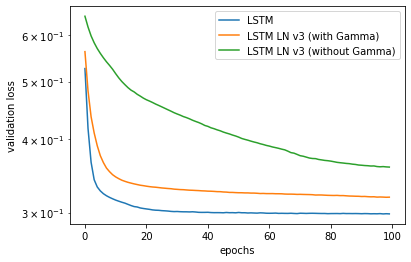

In [29]:
for key in ["loss", "val_loss"]:
    plt.plot(history[0].history[key])
    plt.plot(history[-1].history[key])
    plt.plot(history4.history[key])
    plt.legend(["LSTM", "LSTM LN v3 (with Gamma)", "LSTM LN v3 (without Gamma)"])
    plt.xlabel("epochs")
    plt.ylabel("training loss" if key == "loss" else "validation loss")
    plt.yscale("log")
    plt.show()